In [1]:
"""Exploratory Data Analysis: Protein Mutation Stability Prediction Dataset

Objective: Conduct rigorous exploratory data analysis on a protein mutation dataset for ΔΔG prediction. 
           This analysis will inform model architecture choices, preprocessing strategies, 
           and identify potential data quality issues that could compromise model performance.

Dataset: `k50_cleaned.csv` containing protein mutation data with thermodynamic stability measurements (ddG)."""

'Exploratory Data Analysis: Protein Mutation Stability Prediction Dataset\n\nObjective: Conduct rigorous exploratory data analysis on a protein mutation dataset for ΔΔG prediction. \n           This analysis will inform model architecture choices, preprocessing strategies, \n           and identify potential data quality issues that could compromise model performance.\n\nDataset: `k50_cleaned.csv` containing protein mutation data with thermodynamic stability measurements (ddG).'

In [ ]:
"""
IMPORTS & CONFIGURATION
Setup required libraries, plotting styles, and global configuration.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from pathlib import Path
from typing import Tuple, Dict, List, Optional

warnings.filterwarnings('ignore')

# Configure plotting style
def setup_plotting_style() -> None:
    """Configure matplotlib and seaborn for consistent visualization."""
    sns.set_style('whitegrid')
    plt.rcParams['figure.figsize'] = (12, 6)
    plt.rcParams['font.size'] = 10

setup_plotting_style()

# Initialize paths
DATA_PATH = Path(r'D:\ML_Project\k50_cleaned.csv')

# Load dataset
def load_dataset(filepath: str | Path) -> pd.DataFrame:
    """Load dataset and print summary statistics.
    
    Args:
        filepath: Path to the CSV file
        
    Returns:
        Loaded DataFrame
    """
    df = pd.read_csv(filepath)
    print(f"✓ Dataset loaded successfully: {df.shape[0]} samples, {df.shape[1]} features")
    return df

df = load_dataset(DATA_PATH)

Dataset loaded successfully: 375560 samples, 11 features


In [ ]:
"""
MODULE 1: DATA INTEGRITY & SANITY CHECKS
Functions to validate dataset structure, detect missing values, and identify duplicates.
"""

def analyze_basic_info(df: pd.DataFrame) -> None:
    """Display basic dataset information (shape, dtypes, sample rows)."""
    print("\n" + "="*70)
    print("1. DATASET INTEGRITY & SANITY CHECKS")
    print("="*70)
    print(f"Dataset Shape: {df.shape}")
    print("\nColumn Names and Types:")
    print(df.dtypes)
    print("\nFirst 5 rows:")
    print(df.head())

def analyze_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """Analyze and report missing values in the dataset.
    
    Args:
        df: Input DataFrame
        
    Returns:
        DataFrame with missing value statistics
    """
    missing_counts = df.isnull().sum()
    missing_pct = (missing_counts / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_counts,
        'Percentage': missing_pct
    }).sort_values('Missing Count', ascending=False)
    
    print("\n📊 Missing Values Summary:")
    if missing_df['Missing Count'].sum() == 0:
        print("✓ No missing values detected in the dataset.")
    else:
        print(missing_df[missing_df['Missing Count'] > 0])
        
        # Visualize missing values
        plt.figure(figsize=(10, 6))
        sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
        plt.title('Missing Value Heatmap', fontsize=14, fontweight='bold')
        plt.xlabel('Features')
        plt.ylabel('Sample Index')
        plt.tight_layout()
        plt.show()
    
    return missing_df

def analyze_duplicates(df: pd.DataFrame) -> None:
    """Detect and report duplicate rows."""
    duplicates = df.duplicated().sum()
    dup_pct = (duplicates/len(df)*100) if len(df) > 0 else 0
    
    print(f"\n🔍 Duplicate Analysis:")
    print(f"   Number of duplicate rows: {duplicates}")
    print(f"   Percentage of duplicates: {dup_pct:.2f}%")
    
    if duplicates > 0:
        print("   ⚠️  Warning: Duplicate rows detected. Consider deduplication to prevent data leakage.")

def analyze_identifiers(df: pd.DataFrame, identifier_cols: Optional[List[str]] = None) -> None:
    """Analyze unique counts for key identifier columns.
    
    Args:
        df: Input DataFrame
        identifier_cols: List of identifier column names to check
    """
    if identifier_cols is None:
        identifier_cols = [col for col in ['wt_name', 'wt_cluster', 'position', 'mut_type'] 
                          if col in df.columns]
    
    print(f"\n🏷️  Unique Value Counts for Key Identifiers:")
    for col in identifier_cols:
        print(f"   {col}: {df[col].nunique()} unique values")
    print(f"   Total samples: {len(df)}")

# Execute data integrity checks
analyze_basic_info(df)
missing_df = analyze_missing_values(df)
analyze_duplicates(df)
analyze_identifiers(df)

Dataset Shape: (375560, 11)
Column Names and Types:
name                object
wt_name             object
wt_cluster          object
wt_seq              object
mut_seq             object
mut_type            object
wt_res              object
pos                  int64
mut_res             object
ddG                float64
stability_class      int64
dtype: object
First 5 rows:
Missing Values Summary:
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []
No missing values detected in the dataset.
Skipping missing value heatmap - no missing values present.
Number of duplicate rows: 0
Percentage of duplicates: 0.00%
Unique Value Counts for Key Identifiers:
wt_name: 396 unique values
wt_cluster: 128 unique values
mut_type: 24991 unique values
Total samples: 375560


'\n**Analysis:** \nHigh cardinality in cluster or protein identifiers indicates diversity in the dataset.\nHowever, imbalanced representation across clusters can lead to overfitting on dominant proteins during training.\n'

ΔΔG Descriptive Statistics:
count    375560.000000
mean          0.782204
std           1.016334
min          -3.334218
25%           0.062088
50%           0.526892
75%           1.332763
max           5.392123
Name: ddG, dtype: float64
nSkewness: 0.963
Kurtosis: 0.923


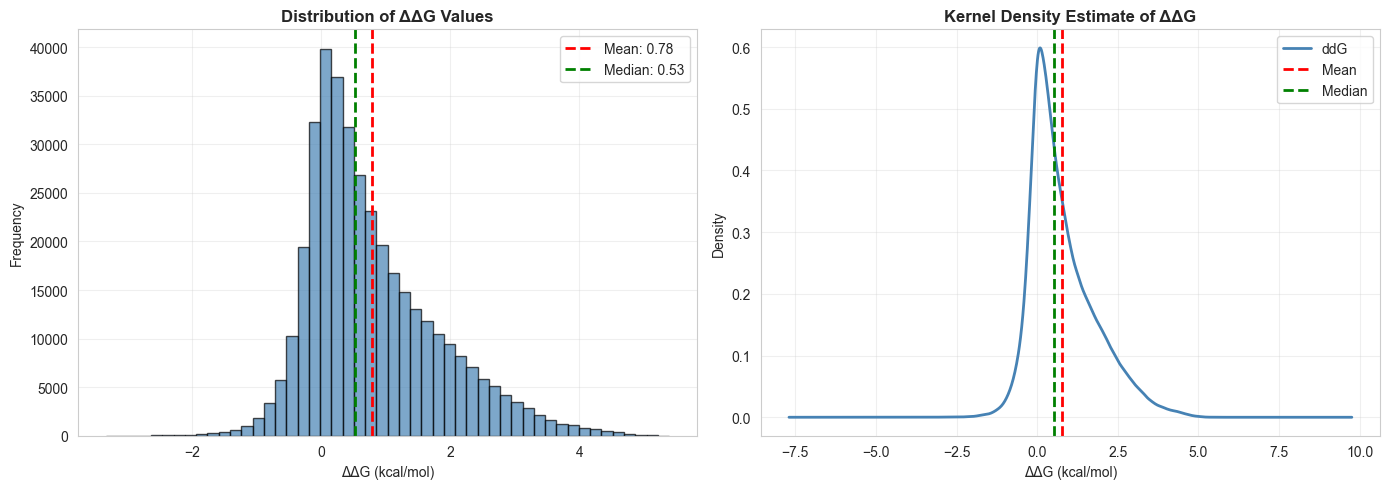

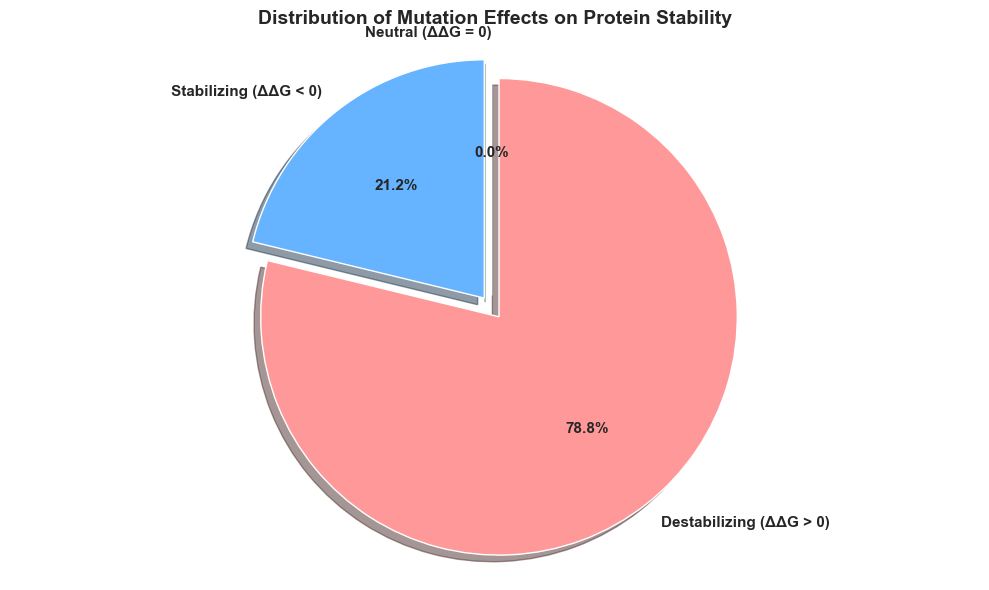

Stabilizing mutations: 79647 (21.2%)
Destabilizing mutations: 295913 (78.8%)
Neutral mutations: 0 (0.0%)


'\n**Analysis:** \nClass imbalance between stabilizing and destabilizing mutations affects model training.\nIf converting to a classification problem, the minority class requires special attention through techniques like SMOTE, class weighting, or stratified sampling.\nMost natural mutations are destabilizing, which should be reflected in the data.\n'

In [ ]:
"""
MODULE 2: TARGET VARIABLE (ddG) ANALYSIS
Functions to analyze the distribution and properties of the ΔΔG target variable.
"""

def get_target_column(df: pd.DataFrame, default_target: str = 'ddG') -> str:
    """Identify target column, falling back to first numerical column if needed.
    
    Args:
        df: Input DataFrame
        default_target: Default target column name
        
    Returns:
        Name of the target column
    """
    if default_target in df.columns:
        return default_target
    
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) > 0:
        target = num_cols[0]
        print(f"⚠️  '{default_target}' column not found. Using '{target}' as target variable.")
        return target
    
    raise ValueError("No numerical columns found for target variable.")

def analyze_target_statistics(df: pd.DataFrame, target_col: str = 'ddG') -> Dict[str, float]:
    """Compute and display descriptive statistics for the target variable.
    
    Args:
        df: Input DataFrame
        target_col: Name of target column
        
    Returns:
        Dictionary of statistical measures
    """
    print("\n" + "="*70)
    print("2. TARGET VARIABLE (ΔΔG) DEEP ANALYSIS")
    print("="*70)
    
    stats_dict = {
        'mean': df[target_col].mean(),
        'median': df[target_col].median(),
        'std': df[target_col].std(),
        'skewness': df[target_col].skew(),
        'kurtosis': df[target_col].kurtosis()
    }
    
    print(f"\n📈 ΔΔG Descriptive Statistics:")
    print(df[target_col].describe())
    print(f"\nSkewness: {stats_dict['skewness']:.3f}")
    print(f"Kurtosis: {stats_dict['kurtosis']:.3f}")
    
    return stats_dict

def plot_target_distribution(df: pd.DataFrame, target_col: str = 'ddG') -> None:
    """Create histogram and KDE plots for target variable distribution."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram with KDE
    axes[0].hist(df[target_col], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0].axvline(df[target_col].mean(), color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: {df[target_col].mean():.2f}')
    axes[0].axvline(df[target_col].median(), color='green', linestyle='--', linewidth=2, 
                    label=f'Median: {df[target_col].median():.2f}')
    axes[0].set_xlabel('ΔΔG (kcal/mol)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of ΔΔG Values', fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # KDE plot
    df[target_col].plot(kind='kde', ax=axes[1], color='steelblue', linewidth=2)
    axes[1].axvline(df[target_col].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    axes[1].axvline(df[target_col].median(), color='green', linestyle='--', linewidth=2, label='Median')
    axes[1].set_xlabel('ΔΔG (kcal/mol)')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Kernel Density Estimate of ΔΔG', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def analyze_mutation_effects(df: pd.DataFrame, target_col: str = 'ddG') -> Dict[str, int]:
    """Categorize mutations as stabilizing, destabilizing, or neutral.
    
    Args:
        df: Input DataFrame
        target_col: Name of target column
        
    Returns:
        Dictionary with counts of each mutation type
    """
    stabilizing = (df[target_col] < 0).sum()
    destabilizing = (df[target_col] > 0).sum()
    neutral = (df[target_col] == 0).sum()
    
    counts = {
        'stabilizing': stabilizing,
        'destabilizing': destabilizing,
        'neutral': neutral
    }
    
    # Create pie chart
    labels = ['Stabilizing (ΔΔG < 0)', 'Destabilizing (ΔΔG > 0)', 'Neutral (ΔΔG = 0)']
    sizes = [stabilizing, destabilizing, neutral]
    colors = ['#66b3ff', '#ff9999', '#99ff99']
    explode = (0.05, 0.05, 0.05)
    
    plt.figure(figsize=(10, 6))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
    plt.title('Distribution of Mutation Effects on Protein Stability', fontsize=14, fontweight='bold')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    print(f"\n🔬 Mutation Effect Distribution:")
    print(f"   Stabilizing mutations: {stabilizing} ({stabilizing/len(df)*100:.1f}%)")
    print(f"   Destabilizing mutations: {destabilizing} ({destabilizing/len(df)*100:.1f}%)")
    print(f"   Neutral mutations: {neutral} ({neutral/len(df)*100:.1f}%)")
    
    return counts

# Execute target variable analysis
target_col = get_target_column(df)
target_stats = analyze_target_statistics(df, target_col)
plot_target_distribution(df, target_col)
mutation_effects = analyze_mutation_effects(df, target_col)

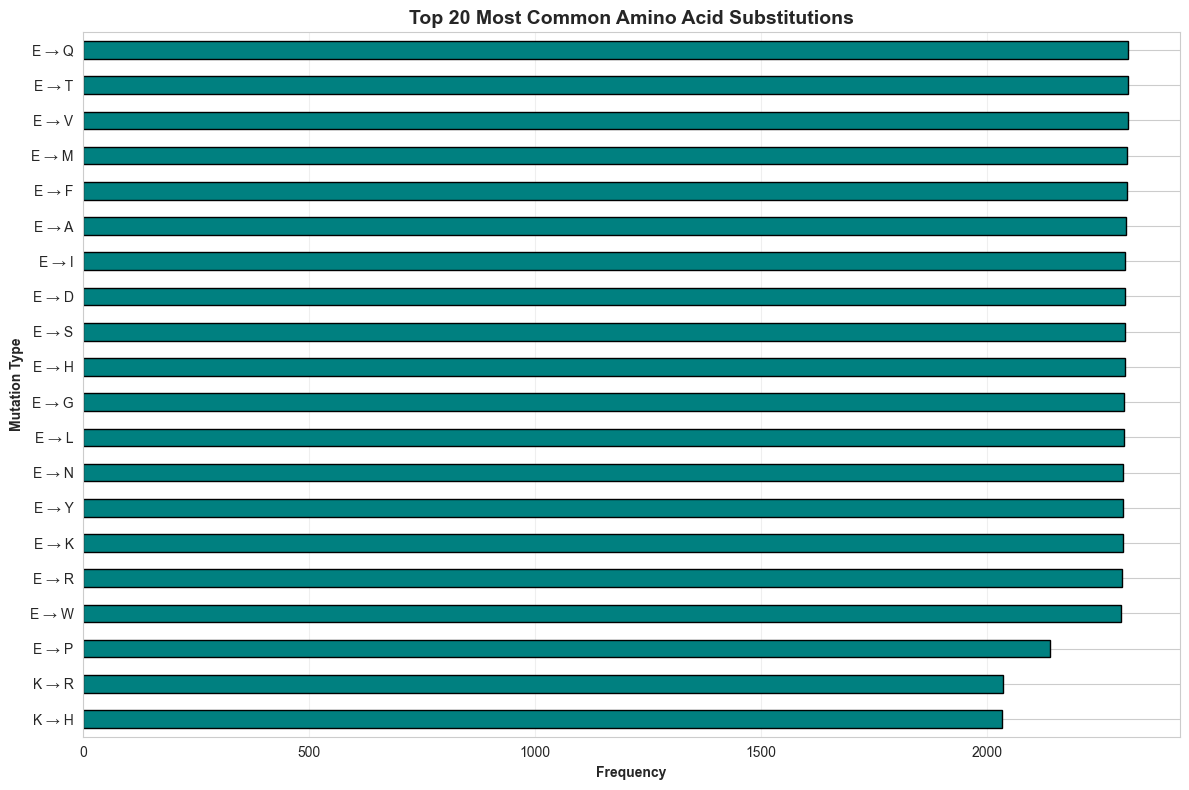

Total unique mutation types: 380
nTop 10 mutations represent 6.1% of the dataset


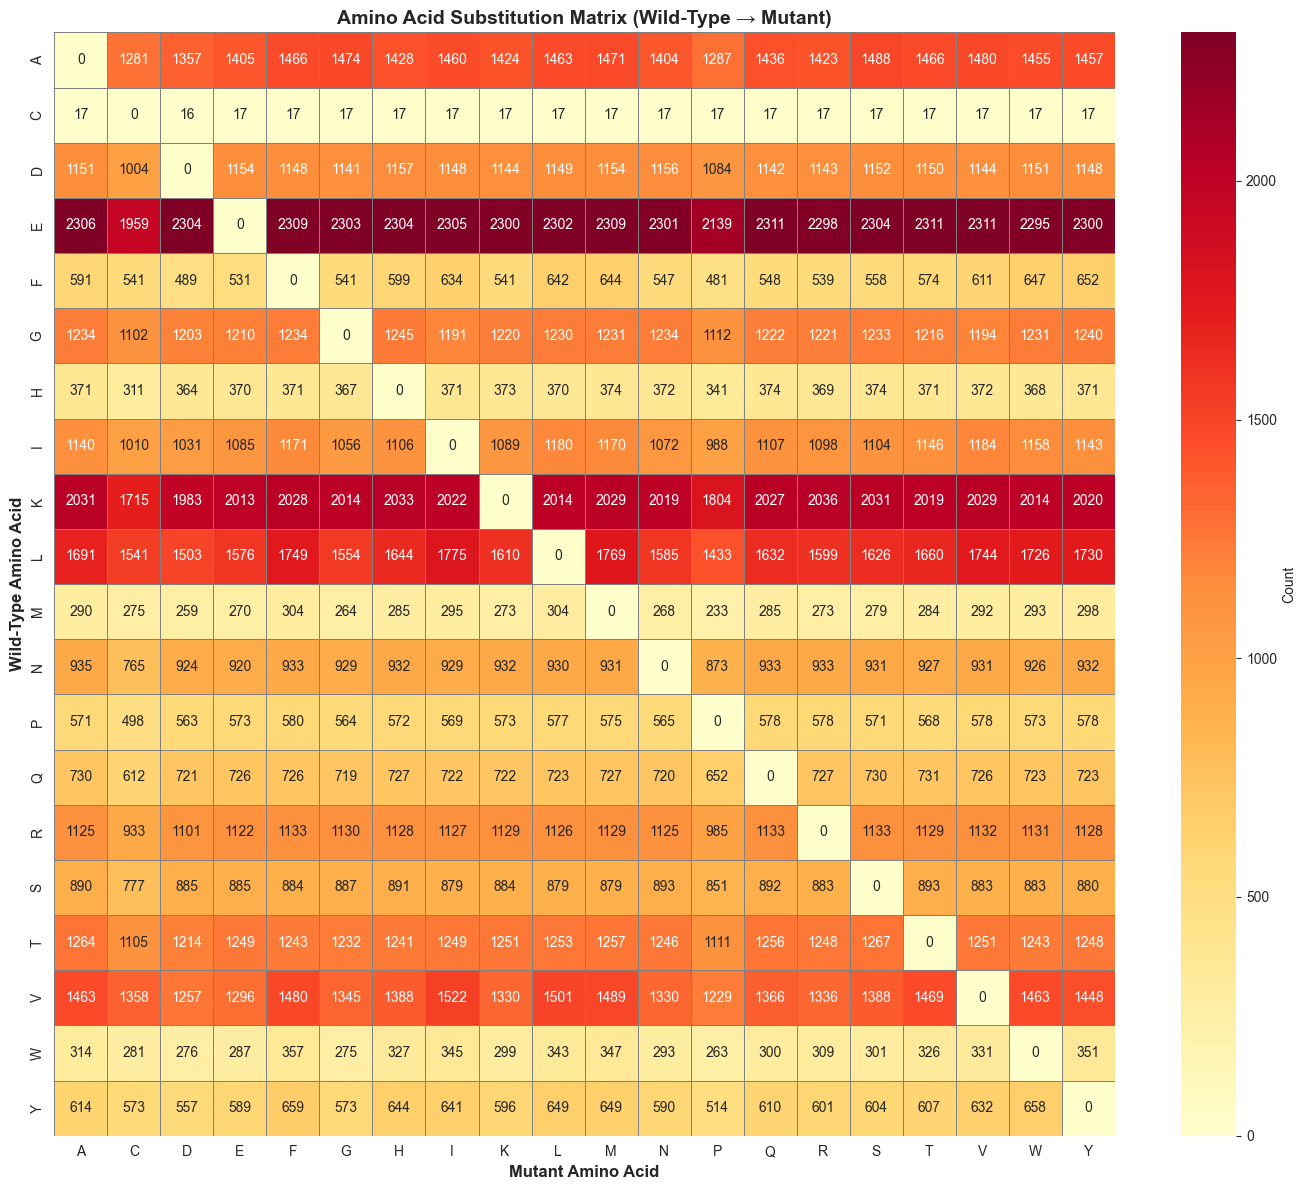

Top 10 amino acid transitions:
E → V: 2311 occurrences
E → Q: 2311 occurrences
E → T: 2311 occurrences
E → M: 2309 occurrences
E → F: 2309 occurrences
E → A: 2306 occurrences
E → I: 2305 occurrences
E → D: 2304 occurrences
E → H: 2304 occurrences
E → S: 2304 occurrences


'    \n**Analysis:** \nThe transition matrix reveals substitution preferences.\nDiagonal elements represent self-mutations (should be absent or minimal).\nOff-diagonal patterns show whether mutations follow biochemical similarity (e.g., hydrophobic to hydrophobic) or are uniformly distributed.\nSparse regions indicate undersampled mutation types that may cause prediction uncertainty."\n'

In [ ]:
"""
MODULE 3: MUTATION LANDSCAPE ANALYSIS
Functions to analyze amino acid substitution patterns and transition matrices.
"""

def create_mutation_strings(df: pd.DataFrame, wt_col: str = 'wt_res', 
                           mut_col: str = 'mut_res') -> pd.Series:
    """Create human-readable mutation strings (e.g., 'A → V').
    
    Args:
        df: Input DataFrame
        wt_col: Wild-type amino acid column name
        mut_col: Mutant amino acid column name
        
    Returns:
        Series of mutation strings
    """
    if wt_col in df.columns and mut_col in df.columns:
        return df[wt_col] + ' → ' + df[mut_col]
    return None

def plot_top_mutations(df: pd.DataFrame, target_col: str = 'ddG', 
                      wt_col: str = 'wt_res', mut_col: str = 'mut_res', 
                      top_n: int = 20) -> pd.Series:
    """Plot the most common amino acid substitutions.
    
    Args:
        df: Input DataFrame
        target_col: Target column name
        wt_col: Wild-type amino acid column name
        mut_col: Mutant amino acid column name
        top_n: Number of top mutations to display
        
    Returns:
        Series of top mutations
    """
    print("\n" + "="*70)
    print("3. MUTATION LANDSCAPE ANALYSIS")
    print("="*70)
    
    if wt_col not in df.columns or mut_col not in df.columns:
        print("⚠️  Amino acid columns not found. Skipping mutation landscape analysis.")
        return None
    
    # Create mutation strings
    mutations = create_mutation_strings(df, wt_col, mut_col)
    mutation_counts = mutations.value_counts().head(top_n)
    
    plt.figure(figsize=(12, 8))
    mutation_counts.plot(kind='barh', color='teal', edgecolor='black')
    plt.xlabel('Frequency', fontweight='bold')
    plt.ylabel('Mutation Type', fontweight='bold')
    plt.title(f'Top {top_n} Most Common Amino Acid Substitutions', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    print(f"\n🧬 Mutation Statistics:")
    print(f"   Total unique mutation types: {mutations.nunique()}")
    print(f"   Top 10 mutations represent {mutation_counts.head(10).sum()/len(df)*100:.1f}% of dataset")
    
    return mutation_counts

def plot_transition_matrix(df: pd.DataFrame, wt_col: str = 'wt_res', 
                          mut_col: str = 'mut_res') -> pd.DataFrame:
    """Create and visualize amino acid transition matrix.
    
    Args:
        df: Input DataFrame
        wt_col: Wild-type amino acid column name
        mut_col: Mutant amino acid column name
        
    Returns:
        Transition matrix DataFrame
    """
    if wt_col not in df.columns or mut_col not in df.columns:
        return None
    
    # Create transition matrix
    transition_matrix = pd.crosstab(df[wt_col], df[mut_col])
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(transition_matrix, cmap='YlOrRd', annot=True, fmt='d', 
                cbar_kws={'label': 'Count'}, linewidths=0.5, linecolor='gray')
    plt.xlabel('Mutant Amino Acid', fontweight='bold', fontsize=12)
    plt.ylabel('Wild-Type Amino Acid', fontweight='bold', fontsize=12)
    plt.title('Amino Acid Substitution Matrix (Wild-Type → Mutant)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Most common transitions
    transition_pairs = transition_matrix.stack().sort_values(ascending=False).head(10)
    print(f"\n🔀 Top 10 amino acid transitions:")
    for (wt, mut), count in transition_pairs.items():
        print(f"   {wt} → {mut}: {count} occurrences")
    
    return transition_matrix

# Execute mutation landscape analysis
top_mutations = plot_top_mutations(df, target_col, 'wt_res', 'mut_res')
transition_matrix = plot_transition_matrix(df, 'wt_res', 'mut_res')

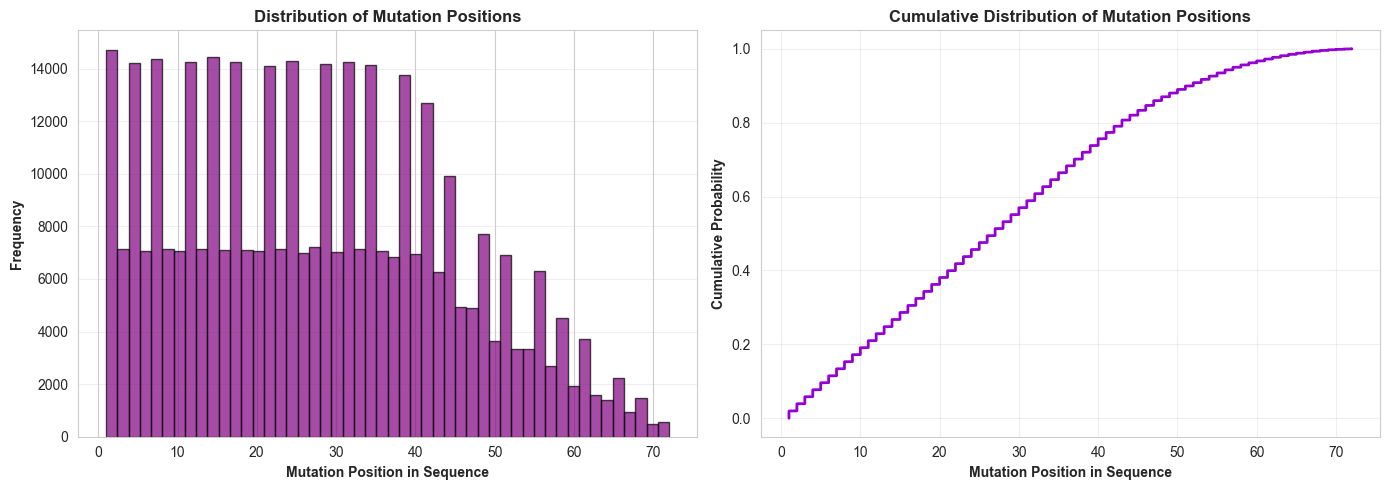

Position range: 1 to 72
Mean position: 27.8
Median position: 27.0


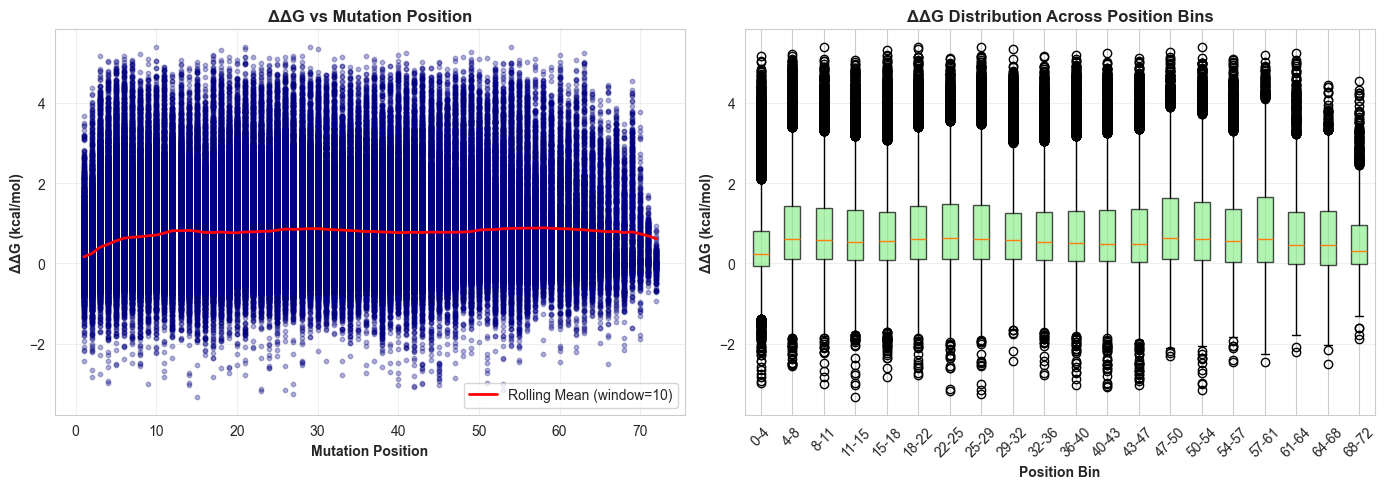

Pearson correlation (position vs ddG): 0.036 (p-value: 0.0000)


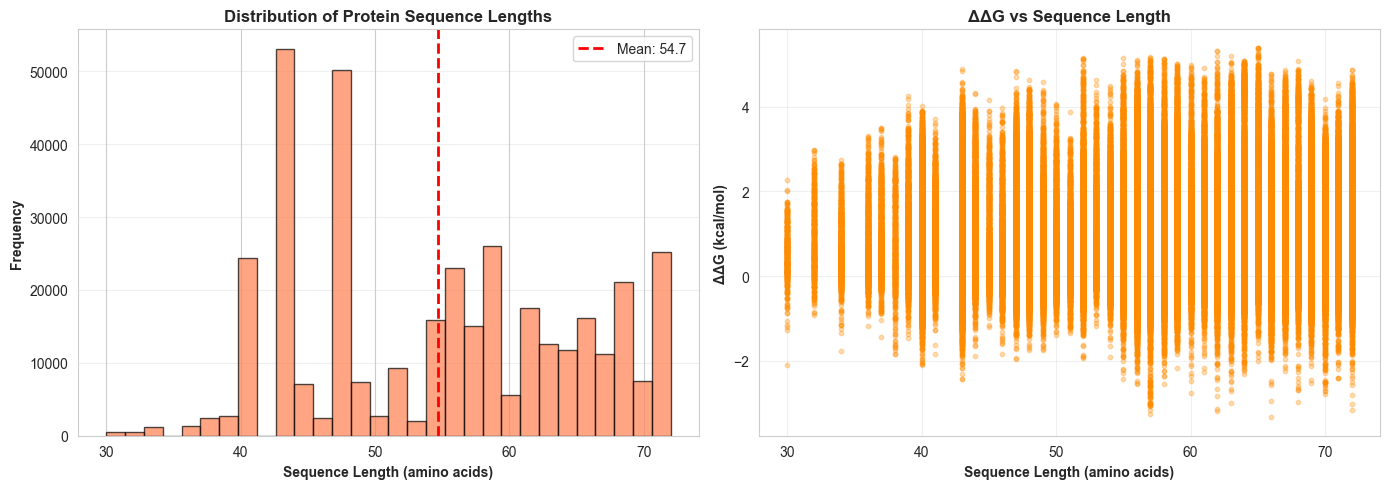

Sequence length statistics:
  Range: 30 - 72 amino acids
  Mean: 54.7 ± 10.3 amino acids
nPearson correlation (sequence length vs ddG): 0.053 (p-value: 0.0000)


'\n**Analysis:** \nSequence length variation affects model architecture choices.\nVariable-length inputs require padding or attention mechanisms.\nCorrelation between sequence length and ΔΔG may indicate size-dependent biophysical effects or dataset composition bias (e.g., different protein families with distinct stability profiles).\n\n'

In [ ]:
"""
MODULE 4: POSITION & SEQUENCE-LEVEL BIAS ANALYSIS
Functions to analyze mutation position distribution and sequence length effects.
"""

def analyze_position_distribution(df: pd.DataFrame, pos_col: str = 'pos') -> None:
    """Analyze and visualize mutation position distribution.
    
    Args:
        df: Input DataFrame
        pos_col: Position column name
    """
    print("\n" + "="*70)
    print("4. POSITION & SEQUENCE-LEVEL BIAS ANALYSIS")
    print("="*70)
    
    if pos_col not in df.columns:
        print(f"⚠️  Position column '{pos_col}' not found. Skipping position analysis.")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram of positions
    axes[0].hist(df[pos_col], bins=50, color='purple', alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('Mutation Position in Sequence', fontweight='bold')
    axes[0].set_ylabel('Frequency', fontweight='bold')
    axes[0].set_title('Distribution of Mutation Positions', fontweight='bold')
    axes[0].grid(alpha=0.3, axis='y')
    
    # Cumulative distribution
    position_sorted = np.sort(df[pos_col])
    cumulative = np.arange(1, len(position_sorted) + 1) / len(position_sorted)
    axes[1].plot(position_sorted, cumulative, color='darkviolet', linewidth=2)
    axes[1].set_xlabel('Mutation Position in Sequence', fontweight='bold')
    axes[1].set_ylabel('Cumulative Probability', fontweight='bold')
    axes[1].set_title('Cumulative Distribution of Mutation Positions', fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📍 Position Statistics:")
    print(f"   Range: {df[pos_col].min()} to {df[pos_col].max()}")
    print(f"   Mean: {df[pos_col].mean():.1f}")
    print(f"   Median: {df[pos_col].median():.1f}")

def analyze_ddg_vs_position(df: pd.DataFrame, pos_col: str = 'pos', 
                           target_col: str = 'ddG') -> None:
    """Analyze relationship between mutation position and ΔΔG.
    
    Args:
        df: Input DataFrame
        pos_col: Position column name
        target_col: Target column name
    """
    if pos_col not in df.columns or target_col not in df.columns:
        return
    
    # Create position bins
    df_copy = df.copy()
    df_copy['position_bin'] = pd.cut(df_copy[pos_col], bins=20)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot with trend
    axes[0].scatter(df_copy[pos_col], df_copy[target_col], alpha=0.3, s=10, color='navy')
    
    # Add rolling mean
    df_sorted = df_copy.sort_values(pos_col)
    rolling_mean = df_sorted.groupby(pos_col)[target_col].mean().rolling(window=10, min_periods=1).mean()
    axes[0].plot(rolling_mean.index, rolling_mean.values, color='red', linewidth=2, 
                 label='Rolling Mean (window=10)')
    
    axes[0].set_xlabel('Mutation Position', fontweight='bold')
    axes[0].set_ylabel('ΔΔG (kcal/mol)', fontweight='bold')
    axes[0].set_title('ΔΔG vs Mutation Position', fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Boxplot by position bins
    position_bin_stats = df_copy.groupby('position_bin')[target_col].median().sort_index()
    axes[1].boxplot([df_copy[df_copy['position_bin'] == bin_val][target_col].values 
                     for bin_val in position_bin_stats.index],
                    labels=[f"{int(interval.left)}-{int(interval.right)}" 
                           for interval in position_bin_stats.index],
                    patch_artist=True,
                    boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1].set_xlabel('Position Bin', fontweight='bold')
    axes[1].set_ylabel('ΔΔG (kcal/mol)', fontweight='bold')
    axes[1].set_title('ΔΔG Distribution Across Position Bins', fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Correlation
    corr, p_value = stats.pearsonr(df_copy[pos_col], df_copy[target_col])
    print(f"\n📐 Position-Target Correlation:")
    print(f"   Pearson r: {corr:.3f} (p-value: {p_value:.4f})")

def analyze_sequence_length(df: pd.DataFrame, seq_col: str = 'wt_seq', 
                           target_col: str = 'ddG') -> None:
    """Analyze sequence length distribution and its relationship to target.
    
    Args:
        df: Input DataFrame
        seq_col: Sequence column name
        target_col: Target column name
    """
    if seq_col not in df.columns:
        print(f"⚠️  Sequence column '{seq_col}' not found. Skipping sequence length analysis.")
        return
    
    df_copy = df.copy()
    df_copy['seq_length'] = df_copy[seq_col].str.len()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    axes[0].hist(df_copy['seq_length'], bins=30, color='coral', alpha=0.7, edgecolor='black')
    axes[0].axvline(df_copy['seq_length'].mean(), color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: {df_copy["seq_length"].mean():.1f}')
    axes[0].set_xlabel('Sequence Length (amino acids)', fontweight='bold')
    axes[0].set_ylabel('Frequency', fontweight='bold')
    axes[0].set_title('Distribution of Protein Sequence Lengths', fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3, axis='y')
    
    # ddG vs sequence length
    axes[1].scatter(df_copy['seq_length'], df_copy[target_col], alpha=0.3, s=10, color='darkorange')
    axes[1].set_xlabel('Sequence Length (amino acids)', fontweight='bold')
    axes[1].set_ylabel('ΔΔG (kcal/mol)', fontweight='bold')
    axes[1].set_title('ΔΔG vs Sequence Length', fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    corr, p_value = stats.pearsonr(df_copy['seq_length'], df_copy[target_col])
    print(f"\n📏 Sequence Length Statistics:")
    print(f"   Range: {df_copy['seq_length'].min()} - {df_copy['seq_length'].max()} amino acids")
    print(f"   Mean ± Std: {df_copy['seq_length'].mean():.1f} ± {df_copy['seq_length'].std():.1f} amino acids")
    print(f"   Correlation with ΔΔG: r = {corr:.3f} (p-value: {p_value:.4f})")

# Execute position and sequence analysis
analyze_position_distribution(df, 'pos')
analyze_ddg_vs_position(df, 'pos', target_col)
analyze_sequence_length(df, 'wt_seq', target_col)

Cluster/Protein Statistics (using 'wt_cluster'):
  Total unique clusters: 128
  Mean samples per cluster: 2934.1
  Median samples per cluster: 1209.5
  Max samples in a cluster: 37981
  Min samples in a cluster: 544


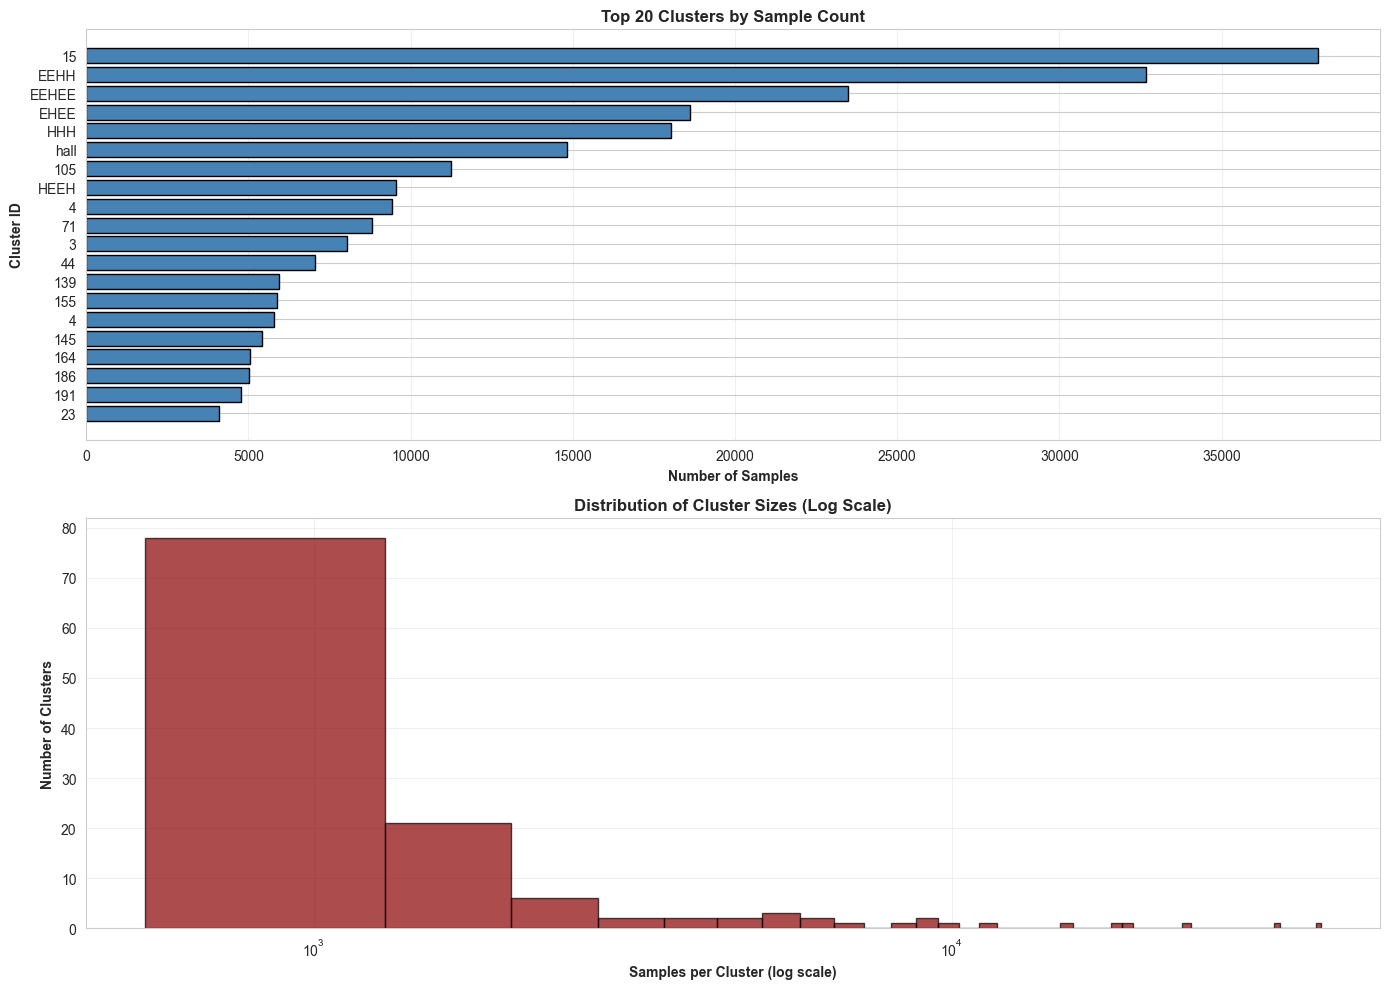

nTop 10 clusters represent 49.2% of all samples


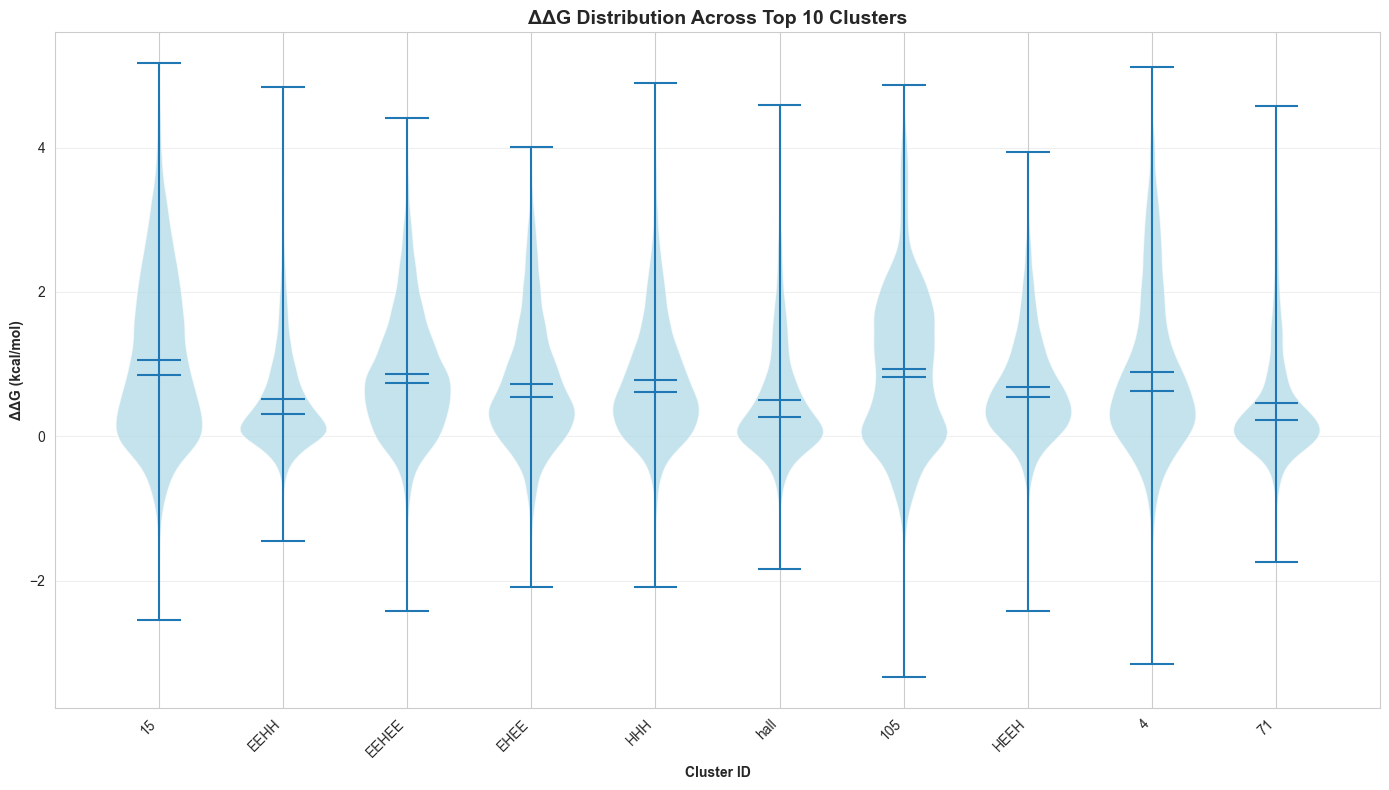

nΔΔG statistics by cluster:
  Range of cluster means: 0.26 to 1.67 kcal/mol
  Standard deviation of cluster means: 0.26 kcal/mol


'\n**Analysis:** \nDistinct ΔΔG distributions across clusters indicate protein-specific stability characteristics.\nThis heterogeneity is biologically meaningful (different proteins have different fold stabilities) but creates a domain adaptation challenge.\nCluster-stratified cross-validation is essential to avoid data leakage.\n\n\nData Leakage Warning\n\nMANDATORY VALIDATION STRATEGY:\n\n1. Train/Test Split: Must be performed at the cluster level, not at the mutation level\n2. Cross-Validation: Use GroupKFold with cluster as the grouping variable\n3. Risk: Random splits will place homologous sequences in both train and test sets, causing:\n   - Inflated performance metrics (10-20% overestimation common)\n   - Failure to generalize to novel protein families\n   - Invalid scientific conclusions about model capability\n\nRecommendation:\nReport both within-cluster and across-cluster performance to distinguish memorization from generalization.\n   \n'

In [ ]:
"""
MODULE 5: CLUSTER-LEVEL LEAKAGE & BIAS CHECK
Functions to analyze cluster distribution and detect potential data leakage.
"""

def analyze_cluster_distribution(df: pd.DataFrame, cluster_col: str = 'wt_cluster') -> pd.Series:
    """Analyze cluster/protein distribution in dataset.
    
    Args:
        df: Input DataFrame
        cluster_col: Cluster column name
        
    Returns:
        Series of cluster counts
    """
    print("\n" + "="*70)
    print("5. CLUSTER-LEVEL LEAKAGE & BIAS CHECK")
    print("="*70)
    
    cluster_cols = [col for col in [cluster_col, 'wt_name'] if col in df.columns]
    if not cluster_cols:
        print(f"⚠️  Cluster columns not found. Skipping cluster analysis.")
        return None
    
    cluster_col = cluster_cols[0]
    cluster_counts = df[cluster_col].value_counts()
    
    print(f"\n🔗 Cluster/Protein Statistics (using '{cluster_col}'):")
    print(f"   Total unique clusters: {len(cluster_counts)}")
    print(f"   Mean samples per cluster: {cluster_counts.mean():.1f}")
    print(f"   Median samples per cluster: {cluster_counts.median():.1f}")
    print(f"   Max samples in a cluster: {cluster_counts.max()}")
    print(f"   Min samples in a cluster: {cluster_counts.min()}")
    
    return cluster_counts

def plot_cluster_distribution(cluster_counts: pd.Series, top_n: int = 20) -> None:
    """Visualize cluster size distribution.
    
    Args:
        cluster_counts: Series of cluster counts
        top_n: Number of top clusters to display
    """
    top_clusters = cluster_counts.head(top_n)
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Bar plot of top clusters
    axes[0].barh(range(len(top_clusters)), top_clusters.values, color='steelblue', edgecolor='black')
    axes[0].set_yticks(range(len(top_clusters)))
    axes[0].set_yticklabels(top_clusters.index)
    axes[0].set_xlabel('Number of Samples', fontweight='bold')
    axes[0].set_ylabel('Cluster ID', fontweight='bold')
    axes[0].set_title(f'Top {top_n} Clusters by Sample Count', fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(alpha=0.3, axis='x')
    
    # Distribution on log scale
    axes[1].hist(cluster_counts.values, bins=50, color='darkred', alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Samples per Cluster', fontweight='bold')
    axes[1].set_ylabel('Number of Clusters', fontweight='bold')
    axes[1].set_title('Distribution of Cluster Sizes (Log Scale)', fontweight='bold')
    axes[1].set_xscale('log')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Concentration metric
    top_10_pct = cluster_counts.head(10).sum() / cluster_counts.sum() * 100
    print(f"\n⚠️  Data Concentration:")
    print(f"   Top 10 clusters represent {top_10_pct:.1f}% of all samples")
    print(f"   CRITICAL: This suggests high clustering/leakage risk for train/test splits!")

def plot_cluster_target_distribution(df: pd.DataFrame, cluster_col: str = 'wt_cluster', 
                                    target_col: str = 'ddG') -> None:
    """Analyze ΔΔG distribution across top clusters.
    
    Args:
        df: Input DataFrame
        cluster_col: Cluster column name
        target_col: Target column name
    """
    cluster_counts = df[cluster_col].value_counts()
    top_10_clusters = cluster_counts.head(10).index
    df_top_clusters = df[df[cluster_col].isin(top_10_clusters)]
    
    plt.figure(figsize=(14, 8))
    
    # Create violin plot
    positions = range(len(top_10_clusters))
    data_to_plot = [df_top_clusters[df_top_clusters[cluster_col] == cluster][target_col].values 
                    for cluster in top_10_clusters]
    
    parts = plt.violinplot(data_to_plot, positions=positions, widths=0.7,
                          showmeans=True, showmedians=True)
    
    # Customize violin plot colors
    for pc in parts['bodies']:
        pc.set_facecolor('lightblue')
        pc.set_alpha(0.7)
    
    plt.xticks(positions, top_10_clusters, rotation=45, ha='right')
    plt.xlabel('Cluster ID', fontweight='bold')
    plt.ylabel('ΔΔG (kcal/mol)', fontweight='bold')
    plt.title('ΔΔG Distribution Across Top 10 Clusters', fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    cluster_means = df.groupby(cluster_col)[target_col].mean().sort_values()
    print(f"\n📊 ΔΔG Statistics by Cluster:")
    print(f"   Range of cluster means: {cluster_means.min():.2f} to {cluster_means.max():.2f} kcal/mol")
    print(f"   Std dev of cluster means: {cluster_means.std():.2f} kcal/mol")

# Execute cluster analysis
cluster_counts = analyze_cluster_distribution(df, 'wt_cluster')
if cluster_counts is not None:
    plot_cluster_distribution(cluster_counts)
    plot_cluster_target_distribution(df, 'wt_cluster', target_col)

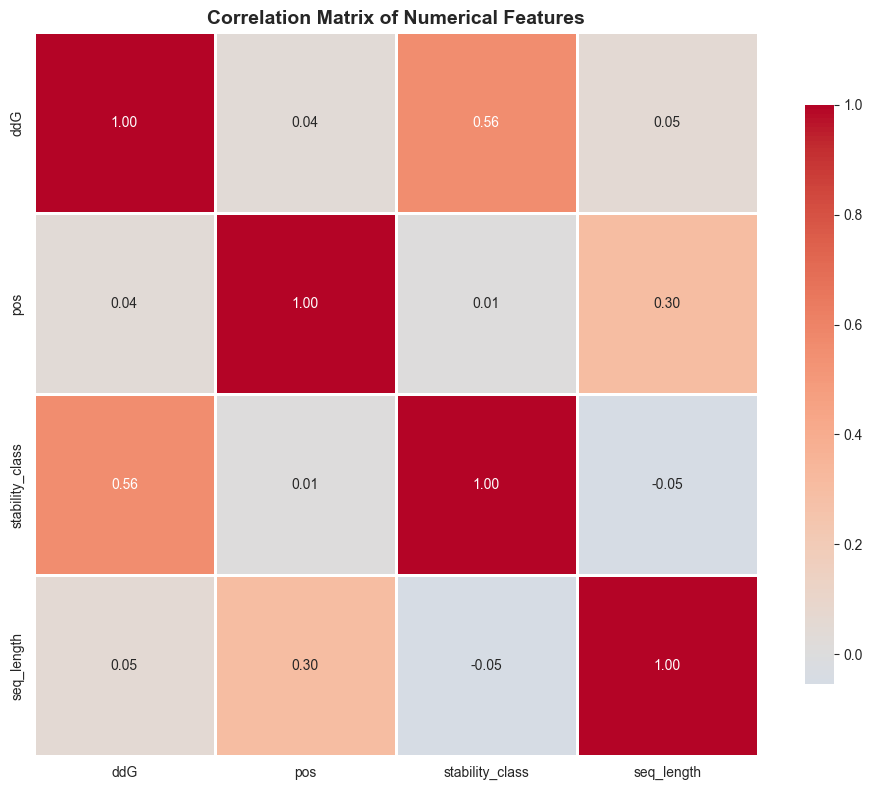

nFeatures most correlated with ΔΔG:
stability_class    0.559035
seq_length         0.053127
pos                0.036260
Name: ddG, dtype: float64


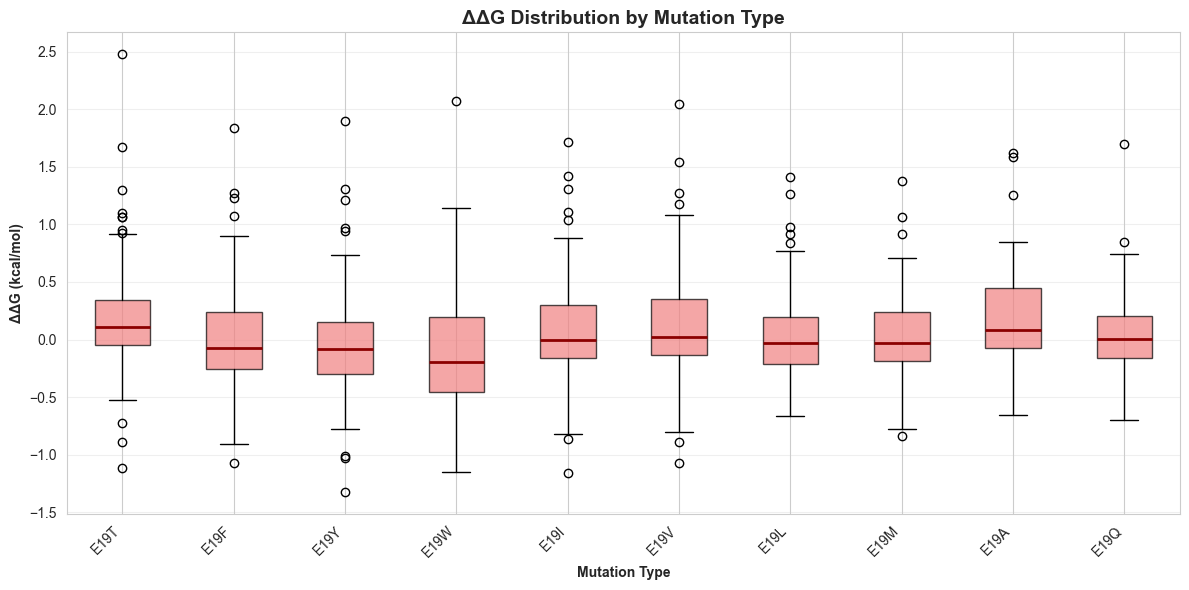

nΔΔG statistics by mutation type:
              mean    median  std  count
mut_type                                
C45R     -3.024501 -3.024501  NaN      1
C45V     -2.940979 -2.940979  NaN      1
C45T     -2.883872 -2.883872  NaN      1
C45I     -2.866792 -2.866792  NaN      1
C45Q     -2.794043 -2.794043  NaN      1
...            ...       ...  ...    ...
M29D      4.402881  4.402881  NaN      1
M26S      4.514294  4.514294  NaN      1
M26G      4.569637  4.569637  NaN      1
M26Q      4.683304  4.683304  NaN      1
M26T      4.950217  4.950217  NaN      1

[24991 rows x 4 columns]


'\n**Analysis:** \nMutation type captures biochemical properties (charge, polarity, size). \nDistinct ΔΔG distributions by mutation type confirm these properties are predictive. \nOne-hot encoding or learned embeddings for mutation type should be considered as features.\nLarge variance within types suggests mutation type alone is insufficient—local context matters.\n\n'

In [ ]:
"""
MODULE 6: FEATURE-TARGET RELATIONSHIPS
Functions to analyze correlations between features and target variable.
"""

def select_numerical_features(df: pd.DataFrame, target_col: str = 'ddG') -> List[str]:
    """Select and prioritize numerical columns for correlation analysis.
    
    Args:
        df: Input DataFrame
        target_col: Target column name
        
    Returns:
        List of numerical columns with target column first
    """
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if target_col in numerical_cols:
        numerical_cols.remove(target_col)
        numerical_cols = [target_col] + numerical_cols
    
    return numerical_cols

def plot_correlation_matrix(df: pd.DataFrame, numerical_cols: List[str]) -> pd.DataFrame:
    """Compute and visualize correlation matrix of numerical features.
    
    Args:
        df: Input DataFrame
        numerical_cols: List of numerical column names
        
    Returns:
        Correlation matrix DataFrame
    """
    print("\n" + "="*70)
    print("6. FEATURE-TARGET RELATIONSHIPS")
    print("="*70)
    
    if len(numerical_cols) < 2:
        print("⚠️  Insufficient numerical features for correlation analysis.")
        return None
    
    corr_matrix = df[numerical_cols].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

def analyze_feature_target_correlations(df: pd.DataFrame, corr_matrix: pd.DataFrame, 
                                       target_col: str = 'ddG', top_n: int = 10) -> None:
    """Identify and display features most correlated with target.
    
    Args:
        df: Input DataFrame
        corr_matrix: Correlation matrix DataFrame
        target_col: Target column name
        top_n: Number of top features to display
    """
    if corr_matrix is None or target_col not in corr_matrix.columns:
        return
    
    ddg_corr = corr_matrix[target_col].drop(target_col).abs().sort_values(ascending=False)
    
    print(f"\n🔗 Top {top_n} Features Correlated with ΔΔG:")
    print(ddg_corr.head(top_n))

def analyze_categorical_target_relationships(df: pd.DataFrame, cat_col: str = 'mut_type', 
                                           target_col: str = 'ddG', top_n: int = 10) -> None:
    """Analyze target distribution across categorical features.
    
    Args:
        df: Input DataFrame
        cat_col: Categorical column name
        target_col: Target column name
        top_n: Number of top categories to display
    """
    if cat_col not in df.columns or target_col not in df.columns:
        print(f"⚠️  Columns '{cat_col}' or '{target_col}' not found.")
        return
    
    top_categories = df[cat_col].value_counts().head(top_n).index
    df_subset = df[df[cat_col].isin(top_categories)]
    
    plt.figure(figsize=(12, 6))
    
    # Box plot by category
    data_to_plot = [df_subset[df_subset[cat_col] == cat][target_col].values 
                    for cat in top_categories]
    
    bp = plt.boxplot(data_to_plot, labels=top_categories, patch_artist=True,
                     boxprops=dict(facecolor='lightcoral', alpha=0.7),
                     medianprops=dict(color='darkred', linewidth=2))
    
    plt.xlabel(f'{cat_col}', fontweight='bold')
    plt.ylabel('ΔΔG (kcal/mol)', fontweight='bold')
    plt.title(f'ΔΔG Distribution by {cat_col}', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print(f"\n📊 ΔΔG statistics by {cat_col}:")
    stats_summary = df.groupby(cat_col)[target_col].agg(['mean', 'median', 'std', 'count']).sort_values('mean')
    print(stats_summary)

# Execute feature-target relationship analysis
numerical_cols = select_numerical_features(df, target_col)
corr_matrix = plot_correlation_matrix(df, numerical_cols)
analyze_feature_target_correlations(df, corr_matrix, target_col)
analyze_categorical_target_relationships(df, 'mut_type', target_col)

In [ ]:
"""
SUMMARY & CONCLUSIONS
Generate a comprehensive summary of the EDA findings.
"""

def generate_eda_summary(df: pd.DataFrame, target_col: str = 'ddG') -> None:
    """Generate a comprehensive summary of EDA findings.
    
    Args:
        df: Input DataFrame
        target_col: Target column name
    """
    print("\n" + "="*70)
    print("EDA SUMMARY & KEY FINDINGS")
    print("="*70)
    
    print("\n📋 DATASET OVERVIEW:")
    print(f"   • Total samples: {len(df):,}")
    print(f"   • Features: {len(df.columns)}")
    print(f"   • Missing values: {df.isnull().sum().sum()}")
    print(f"   • Duplicate rows: {df.duplicated().sum()}")
    
    print(f"\n🎯 TARGET VARIABLE ({target_col}):")
    print(f"   • Mean: {df[target_col].mean():.3f} kcal/mol")
    print(f"   • Std Dev: {df[target_col].std():.3f} kcal/mol")
    print(f"   • Range: [{df[target_col].min():.3f}, {df[target_col].max():.3f}] kcal/mol")
    print(f"   • Skewness: {df[target_col].skew():.3f}")
    
    stabilizing = (df[target_col] < 0).sum()
    destabilizing = (df[target_col] > 0).sum()
    print(f"   • Stabilizing: {stabilizing/len(df)*100:.1f}% | Destabilizing: {destabilizing/len(df)*100:.1f}%")
    
    # Position analysis
    if 'pos' in df.columns:
        print(f"\n📍 POSITION DISTRIBUTION:")
        print(f"   • Range: {df['pos'].min()} - {df['pos'].max()}")
        print(f"   • Mean: {df['pos'].mean():.1f}")
        corr_pos, p_val_pos = stats.pearsonr(df['pos'], df[target_col])
        print(f"   • Correlation with target: r = {corr_pos:.3f} (p < 0.05: {p_val_pos < 0.05})")
    
    # Cluster analysis
    cluster_cols = [col for col in ['wt_cluster', 'wt_name'] if col in df.columns]
    if cluster_cols:
        cluster_counts = df[cluster_cols[0]].value_counts()
        top_10_pct = cluster_counts.head(10).sum() / len(df) * 100
        print(f"\n🔗 CLUSTER ANALYSIS (using '{cluster_cols[0]}'):")
        print(f"   • Unique clusters: {len(cluster_counts)}")
        print(f"   • Top 10 clusters: {top_10_pct:.1f}% of data (⚠️ HIGH LEAKAGE RISK)")
        print(f"   • Recommendation: Use cluster-aware train/test splits!")
    
    print(f"\n🧬 MUTATIONS:")
    if 'wt_res' in df.columns and 'mut_res' in df.columns:
        mutations = df['wt_res'] + ' → ' + df['mut_res']
        print(f"   • Unique mutation types: {mutations.nunique()}")
        print(f"   • Top mutation: {mutations.value_counts().index[0]} ({mutations.value_counts().iloc[0]} samples)")
    
    print("\n✅ RECOMMENDATIONS:")
    print("   1. Use stratified K-fold or cluster-aware splitting to prevent data leakage")
    print("   2. Consider normalizing/standardizing features before modeling")
    print("   3. Check for position/cluster biases in feature engineering")
    print("   4. Handle class imbalance if predicting mutation effects")
    print("   5. Validate model on held-out cluster set for true generalization")
    print("\n" + "="*70 + "\n")

# Generate summary
generate_eda_summary(df, target_col)